# DSLab Homework 1 - Data Science with CO2

## Hand-in Instructions

- __Due: 23.03.2021 23h59 CET__
- `git push` your final verion to the master branch of your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Carbosense

The project Carbosense establishes a uniquely dense CO2 sensor network across Switzerland to provide near-real time information on man-made emissions and CO2 uptake by the biosphere. The main goal of the project is to improve the understanding of the small-scale CO2 fluxes in Switzerland and concurrently to contribute to a better top-down quantification of the Swiss CO2 emissions. The Carbosense network has a spatial focus on the City of Zurich where more than 50 sensors are deployed. Network operations started in July 2017.

<img src="http://carbosense.wdfiles.com/local--files/main:project/CarboSense_MAP_20191113_LowRes.jpg" width="500">

<img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_ZLMT_3.JPG" width="156">  <img src="http://carbosense.wdfiles.com/local--files/main:sensors/LP8_sensor_SMALL.jpg" width="300">

## Description of the homework

In this homework, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich from the Carbosense project. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city **zones** and the zone in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

## Prior knowledge

The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains, forests), are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements, on temperature and humidity.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. **The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements.** 

## To start with

The following csv files in the `../data/carbosense-raw/` folder will be needed: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements `CO2`, the name of the site `LocationName`, a unique sensor identifier `SensorUnit_ID`, and the time instance in which the measurement was taken `timestamp`.
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp `Timestamp`. For each `SensorUnit_ID`, the temperature and the humidity can be found in the corresponding columns of the dataframe `{SensorUnit_ID}.temperature`, `{SensorUnit_ID}.humidity`.
    
3. `sensor_metadata.csv`

   __Description__: It contains the name of the site `LocationName`, the zone index `zone`, the altitude in meters `altitude`, the longitude `lon`, and the latitude `lat`. 

Import the following python packages:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import plotly.graph_objects as go
import os
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [2]:
pd.options.mode.chained_assignment = None

## PART I: Handling time series with pandas (10 points)

### a) **8/10**

Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe. 

* The merged dataframe contains:
    - index: the time instance `timestamp` of the measurements
    - columns: the location of the site `LocationName`, the sensor ID `SensorUnit_ID`, the CO2 measurement `CO2`, the `temperature`, the `humidity`, the `zone`, the `altitude`, the longitude `lon` and the latitude `lat`.

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |



* For each measurement (CO2, humidity, temperature), __take the average over an interval of 30 min__. 

* If there are missing measurements, __interpolate them linearly__ from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [3]:
!git lfs pull

In [4]:
co2_measurements = pd.read_csv("../data/carbosense-raw/CO2_sensor_measurements.csv",
                             sep="\t",
                             parse_dates=['timestamp'])
co2_measurements = co2_measurements.rename({'SensorUnit_ID':'sensor'}, axis=1)

In [5]:
co2_measurements.head()

,timestamp,LocationName,sensor,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


In [6]:
co2_measurements[co2_measurements.LocationName == "ZGHD"].sensor.unique()

array([1014])

In [7]:
co2_measurements.isnull().any(None)

False

In [8]:
co2_measurements['sensor'] = co2_measurements['sensor'].astype(int)

In [9]:
def co2_measurements_resample(df):
    res = df['CO2'].resample('30min').mean().to_frame()
    # Some periods of 30min have 0 datapoints, therefore we need to interpolate
    res = res.interpolate('linear', axis=0)
    res['LocationName'] = df['LocationName'].values[0]
    return res

co2_measurements = co2_measurements.set_index('timestamp') \
                                    .groupby('sensor') \
                                    .apply(co2_measurements_resample)

In [10]:
co2_measurements.isnull().any(None)

False

In [11]:
temp_humidity = pd.read_csv("../data/carbosense-raw/temperature_humidity.csv",
                            sep="\t",
                            parse_dates=['Timestamp'])
temp_humidity = temp_humidity.rename({'Timestamp':'timestamp'}, axis=1)

In [12]:
temp_humidity.head()

,timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.50,95.858139,10.70,94.524902,11.35,90.288681,11.44,90.118927
1,2017-10-01 00:10:00,11.39,92.579407,10.48,92.079681,11.04,93.063873,11.05,90.042633,11.38,...,10.12,97.322983,10.45,95.903915,10.53,94.395203,11.35,90.422195,11.46,90.073151
2,2017-10-01 00:20:00,11.41,92.480225,10.51,92.583221,11.06,93.201202,11.02,89.888138,11.35,...,10.14,97.780746,10.43,95.343155,10.45,94.620270,11.33,91.023010,11.41,89.466614
3,2017-10-01 00:30:00,11.35,91.902298,10.55,92.714828,11.02,92.932266,10.96,89.790863,11.31,...,10.13,97.904724,10.43,95.322174,10.42,94.973129,11.32,91.019196,11.39,89.249176
4,2017-10-01 00:40:00,11.30,91.639084,10.59,92.764420,10.99,92.598480,10.95,89.821381,11.27,...,10.13,97.931427,10.48,96.451324,10.46,95.282120,11.28,90.443176,11.31,88.871521


In [13]:
temp_humidity = pd.melt(temp_humidity, id_vars='timestamp', var_name='sensor.temp_humidity', value_name='measurement')
temp_humidity[['sensor','temp_humidity']] = temp_humidity['sensor.temp_humidity'].str.split('.', expand=True)
temp_humidity = temp_humidity.pivot(index=['timestamp','sensor'], columns='temp_humidity', values='measurement').reset_index()

In [14]:
temp_humidity

temp_humidity,timestamp,sensor,humidity,temperature
0,2017-10-01 00:00:00,1014,92.262787,11.39
1,2017-10-01 00:00:00,1015,91.949982,10.55
2,2017-10-01 00:00:00,1016,92.613739,11.02
3,2017-10-01 00:00:00,1017,89.811844,11.05
4,2017-10-01 00:00:00,1018,91.427368,11.38
...,...,...,...,...
205339,2017-10-31 23:50:00,1291,94.849152,1.96
205340,2017-10-31 23:50:00,1292,96.170944,-0.54
205341,2017-10-31 23:50:00,1297,94.997925,0.05
205342,2017-10-31 23:50:00,1298,83.046478,2.82


In [15]:
temp_humidity['sensor'] = temp_humidity['sensor'].astype(int)

In [16]:
temp_humidity.isnull().any(None)

True

In [17]:
temp_humidity= temp_humidity.set_index('timestamp') \
                             .groupby('sensor') \
                             .apply(lambda df: df[['temperature', 'humidity']]
                                               .interpolate('linear', axis=0) \
                                               .resample('30min').mean())

In [18]:
temp_humidity.isnull().any(None)

False

In [19]:
temp_humidity

temp_humidity               temperature   humidity
sensor timestamp                                  
1014   2017-10-01 00:00:00    11.396667  92.440806
       2017-10-01 00:30:00    11.303333  91.625097
       2017-10-01 01:00:00    11.240000  91.096761
       2017-10-01 01:30:00    11.260000  91.275734
       2017-10-01 02:00:00    11.285000  91.003937
...                                 ...        ...
1299   2017-10-31 21:30:00     3.923333  78.965388
       2017-10-31 22:00:00     3.766667  79.702896
       2017-10-31 22:30:00     3.493333  80.769740
       2017-10-31 23:00:00     3.373333  81.676366
       2017-10-31 23:30:00     3.286667  81.910970

[68448 rows x 2 columns]

In [20]:
metadata = pd.read_csv("../data/carbosense-raw/sensors_metadata.csv", sep="\t")
metadata.head()

,LocationName,zone,altitude,lat,lon
0,AJGR,2,627.8,47.33321,8.480300
1,BSCR,2,462.3,47.35581,8.430070
2,BUDF,10,490.2,47.36270,8.433110
3,KBRL,7,510.5,47.32582,8.537550
4,KTGM,2,530.3,47.32334,8.596422


In [21]:
temp_humidity = temp_humidity.reset_index()
co2_measurements = co2_measurements.reset_index()
final_df = pd.merge(temp_humidity, co2_measurements, how='inner', right_on=['sensor','timestamp'], left_on=['sensor','timestamp'])

In [22]:
final_df = pd.merge(final_df, metadata, left_on='LocationName', right_on='LocationName', validate='m:1')

In [23]:
final_df.isnull().any(None)

False

In [24]:
final_df = final_df.set_index('timestamp')

In [25]:
final_df

,sensor,temperature,humidity,CO2,LocationName,zone,altitude,lat,lon
timestamp,,,,,,,,,
2017-10-01 00:00:00,1014,11.396667,92.440806,595.004391,ZGHD,2,413.5,47.370446,8.523256
2017-10-01 00:30:00,1014,11.303333,91.625097,597.017879,ZGHD,2,413.5,47.370446,8.523256
2017-10-01 01:00:00,1014,11.240000,91.096761,596.487010,ZGHD,2,413.5,47.370446,8.523256
2017-10-01 01:30:00,1014,11.260000,91.275734,598.787639,ZGHD,2,413.5,47.370446,8.523256
2017-10-01 02:00:00,1014,11.285000,91.003937,595.366394,ZGHD,2,413.5,47.370446,8.523256
...,...,...,...,...,...,...,...,...,...
2017-10-31 21:30:00,1299,3.923333,78.965388,477.307329,ZLDW,5,405.9,47.348870,8.536290
2017-10-31 22:00:00,1299,3.766667,79.702896,474.396830,ZLDW,5,405.9,47.348870,8.536290
2017-10-31 22:30:00,1299,3.493333,80.769740,474.406102,ZLDW,5,405.9,47.348870,8.536290


### b) **2/10** 

Export the curated and ready to use timeseries to a csv file, and properly push the merged csv to Git LFS.

In [26]:
os.chdir('..')

In [27]:
!git lfs track -l 

Listing tracked patterns
    data/carbosense-raw/temperature_humidity.csv (.gitattributes)
    data/carbosense-raw/CO2_sensor_measurements.csv (.gitattributes)
    data/carbosense-raw/final_df.csv (.gitattributes)
Listing excluded patterns


In [28]:
save_path = 'data/carbosense-raw/final_df.csv'

In [29]:
!git lfs track data/carbosense-raw/final_df.csv

"data/carbosense-raw/final_df.csv" already supported


In [30]:
!git lfs track -l 

Listing tracked patterns
    data/carbosense-raw/temperature_humidity.csv (.gitattributes)
    data/carbosense-raw/CO2_sensor_measurements.csv (.gitattributes)
    data/carbosense-raw/final_df.csv (.gitattributes)
Listing excluded patterns


In [31]:
final_df.to_csv(save_path, sep='\t')

In [32]:
!git add  data/carbosense-raw/final_df.csv

In [33]:
!git commit -m "df csv file"

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
	modified:   notebooks/DSLab-homework1.ipynb

no changes added to commit


In [34]:
!git push

Everything up-to-date


## PART II: Data visualization (15 points)

### a) **5/15** 
Group the sites based on their altitude, by performing K-means clustering. 
- Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). 
- Wite out the formula of metric you use for Elbow curve. 
- Perform clustering with the optimal number of clusters and add an additional column `altitude_cluster` to the dataframe of the previous question indicating the altitude cluster index. 
- Report your findings.

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [66]:
data= metadata[['LocationName', 'altitude', 'lat', 'lon']]

In [67]:
X= data.altitude.values.reshape(-1,1)

In [68]:
model= KMeans()

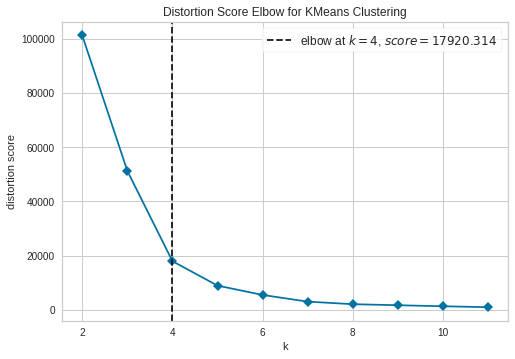

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [69]:
visualizer = KElbowVisualizer(model, k=(2,12), timings = False)
visualizer.fit(X)
visualizer.show()


In [70]:
# From the visualization in the previous cell, the optimal k by the elbow method is 4
optimal_k = 4

In [71]:
# We fit the model with the optimal number of clusters
model = KMeans(n_clusters= optimal_k)
model.fit(X)

KMeans(n_clusters=4)

In [72]:
# we add the assigned cluster index to the dataframe
assigned_clusters = model.labels_
data['cluster_index'] = assigned_clusters

In [73]:
data.head()

,LocationName,altitude,lat,lon,cluster_index
0,AJGR,627.8,47.33321,8.480300,1
1,BSCR,462.3,47.35581,8.430070,0
2,BUDF,490.2,47.36270,8.433110,0
3,KBRL,510.5,47.32582,8.537550,0
4,KTGM,530.3,47.32334,8.596422,0


### b) **4/15** 

Use `plotly` (or other similar graphing libraries) to create an interactive plot of the monthly median CO2 measurement for each site with respect to the altitude. 

Add proper title and necessary hover information to each point, and give the same color to stations that belong to the same altitude cluster.

In [74]:
df = co2_measurements.groupby(by='LocationName').median()

In [75]:
df = df.drop(columns= ["sensor"]).rename(columns= {"CO2" : "CO2_median"})

In [76]:
df

,CO2_median
LocationName,
AJGR,334.785793
BSCR,474.502250
BUDF,422.793126
KBRL,410.100150
KTGM,444.395518
RCTZ,451.003079
SMHK,522.346787
SZGL,488.481426
ULGW,430.143296


In [77]:
# We merge the two dataframes found
result = pd.merge(df, data, on= 'LocationName') 

In [78]:
result.head()

,LocationName,CO2_median,altitude,lat,lon,cluster_index
0,AJGR,334.785793,627.8,47.33321,8.480300,1
1,BSCR,474.502250,462.3,47.35581,8.430070,0
2,BUDF,422.793126,490.2,47.36270,8.433110,0
3,KBRL,410.100150,510.5,47.32582,8.537550,0
4,KTGM,444.395518,530.3,47.32334,8.596422,0


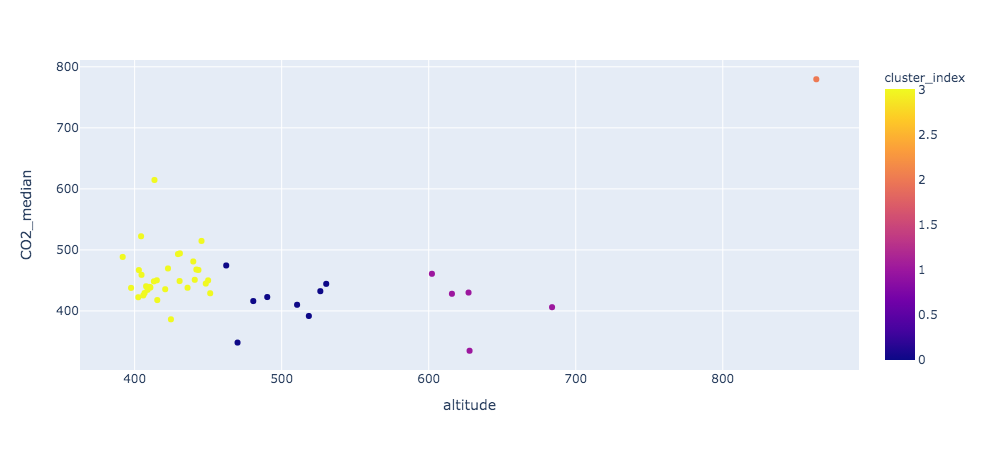

In [79]:
# we visualize the monthly median as a function of the altitude colored according to the clustering result
px.scatter(result, x= 'altitude', y= 'CO2_median', color= 'cluster_index')

### c) **6/15**

Use `plotly` (or other similar graphing libraries) to plot an interactive time-varying density heatmap of the mean daily CO2 concentration for all the stations. Add proper title and necessary hover information.

__Hints:__ Check following pages for more instructions:
- [Animations](https://plotly.com/python/animations/)
- [Density Heatmaps](https://plotly.com/python/mapbox-density-heatmaps/)

In [80]:
# We compute the mean daily CO2 measurements for each site 
s= co2_measurements.groupby(by = ["LocationName", co2_measurements['timestamp'].dt.day]).mean().drop(columns= ["sensor"]).reset_index()

In [81]:
s.head()

,LocationName,timestamp,CO2
0,AJGR,1,336.656408
1,AJGR,2,342.793705
2,AJGR,3,335.531220
3,AJGR,4,335.316507
4,AJGR,5,340.486617


In [82]:
data

,LocationName,altitude,lat,lon,cluster_index
0,AJGR,627.8,47.333210,8.480300,1
1,BSCR,462.3,47.355810,8.430070,0
2,BUDF,490.2,47.362700,8.433110,0
3,KBRL,510.5,47.325820,8.537550,0
4,KTGM,530.3,47.323340,8.596422,0
5,RCTZ,440.9,47.434277,8.506933,3
6,SMHK,404.4,47.394410,8.445830,3
7,SZGL,391.9,47.405815,8.445361,3
8,ULGW,627.1,47.357480,8.469090,1
9,UTLI,863.6,47.351406,8.490318,2


In [83]:
s= pd.merge(s, data, on= ["LocationName"])

In [106]:
s= s.rename(columns={'timestamp' : 'day'})


In [124]:
# compute min and max CO2 mean 
min_CO2_mean= s.CO2.values.min()
max_CO2_mean = s.CO2.values.max()

In [123]:
max_CO2_mean

1462.6464400660886

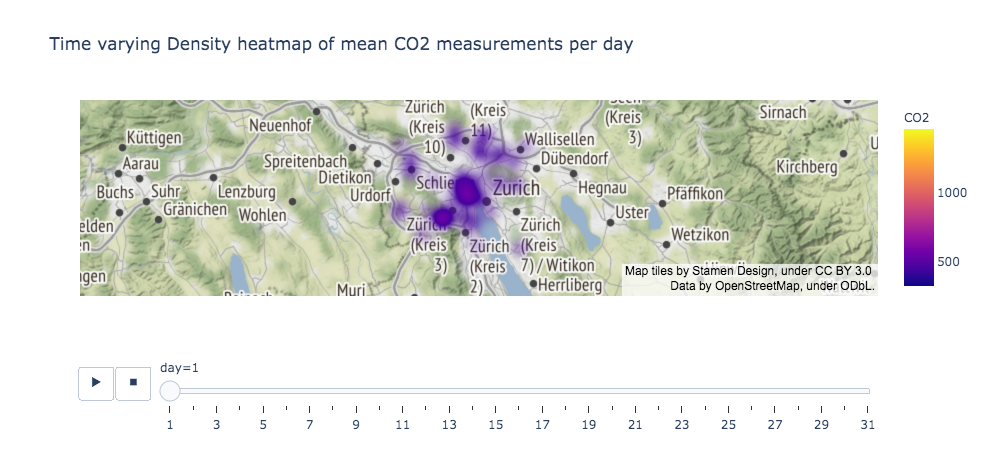

In [119]:
fig = px.density_mapbox(s, lat='lat', lon='lon', z='CO2', radius=20,
                        center=dict(lat=47.37, lon=8.54), zoom=9,
                        mapbox_style="stamen-terrain", animation_frame='day', animation_group= 'LocationName', 
                        hover_name='LocationName', title= 'Time varying Density heatmap of mean CO2 measurements per day',
                        range_color=[min_CO2_mean, max_CO2_mean])



fig.show()

## PART III: Model fitting for data curation (35 points)

### a) **2/35**

The domain experts in charge of these sensors report that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 24. Verify the drift by visualizing the CO2 concentration of the drifting sensor and compare it with some other sensors from the network. 

In [ ]:
co2_measurements[co2_measurements.timestamp.dt.day == 24][co2_measurements.LocationName == "ZSBN"]

### b) **8/35**

The domain experts ask you if you could reconstruct the CO2 concentration of the drifting sensor had the drift not happened. You decide to:
- Fit a linear regression model to the CO2 measurements of the site, by considering as features the covariates not affected by the malfunction (such as temperature and humidity)
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

__Note:__ Cross validation on time series is different from that on other kinds of datasets. The following diagram illustrates the series of training sets (in orange) and validation sets (in blue). For more on time series cross validation, there are a lot of interesting articles available online. scikit-learn provides a nice method [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

![ts_cv](https://player.slideplayer.com/86/14062041/slides/slide_28.jpg)

### c) **10/35**

In your next attempt to solve the problem, you decide to exploit the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar.

- Find the sensors sharing similar conditions with `ZSBN`. Explain your definition of "similar condition".
- Fit a linear regression model to the CO2 measurements of the site, by considering as features:
    - the information of provided by similar sensors
    - the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).
- Create an interactive plot with `plotly` (or other similar graphing libraries):
    - the actual CO2 measurements
    - the values obtained by the prediction of the linear model for the entire month of October
    - the __confidence interval__ obtained from cross validation
- What do you observe? Report your findings.

### d) **10/35**

Now, instead of feeding the model with all features, you want to do something smarter by using linear regression with fewer features.

- Start with the same sensors and features as in question c)
- Leverage at least two different feature selection methods
- Create similar interactive plot as in question c)
- Describe the methods you choose and report your findings

### e) **5/35**

Eventually, you'd like to try something new - __Bayesian Structural Time Series Modelling__ - to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 24. You will use:
- the information of provided by similar sensors - the ones you identified in question c)
- the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.

- Report your findings:
    - Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?
    - Can you try to explain the results?

# That's all, folks!